In [4]:
# Load X data of dimension Nv x 4(including color)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
v = pd.read_csv('hits_and_tracks_3d_events_all.csv', sep=';')
print("features data loaded...")

features data loaded...


In [5]:
#Focus on event_id=0
rows_with_event_id_zero = v[v['event_id'] == 0]
#Extract coordinates and label with hit_id in time-order
new_df=rows_with_event_id_zero[['hit_id','hit_r','hit_theta','hit_z']]
new_df.set_index('hit_id',inplace=True)
#Convert to x, y, z coordinates
new_df['hit_x']=new_df['hit_r']*np.sin(new_df['hit_theta'])
new_df['hit_y']=new_df['hit_r']*np.cos(new_df['hit_theta'])
new_df=new_df[['hit_x','hit_y','hit_z']]
new_df

<ipython-input-5-823aff838165>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['hit_x']=new_df['hit_r']*np.sin(new_df['hit_theta'])
<ipython-input-5-823aff838165>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['hit_y']=new_df['hit_r']*np.cos(new_df['hit_theta'])


,hit_x,hit_y,hit_z
hit_id,,,
0,-0.628298,0.404463,-1.983446
1,-0.718796,-0.803228,-2.997883
2,0.875159,-1.138740,-3.979522
3,1.617943,0.740712,-5.019919
4,-0.636256,2.033484,-6.029640
5,-2.469909,-0.208080,-7.031078
6,-0.351125,-2.810445,-7.993486
7,3.084340,-0.791833,-8.974554
8,1.506305,3.196817,-10.012223


In [6]:
#Reduced adjacency matrix A
cut=5
#A[i][j]==1 implies there is an edge between i, j-th nodes.
A=[[0 for _ in range(cut)] for _ in range(cut)]
#Collect edges with its end in the "cut" bound
for i in range(4):
    A[i][i+1]=1
print("Adjacency matrix prepared...")

Adjacency matrix prepared...


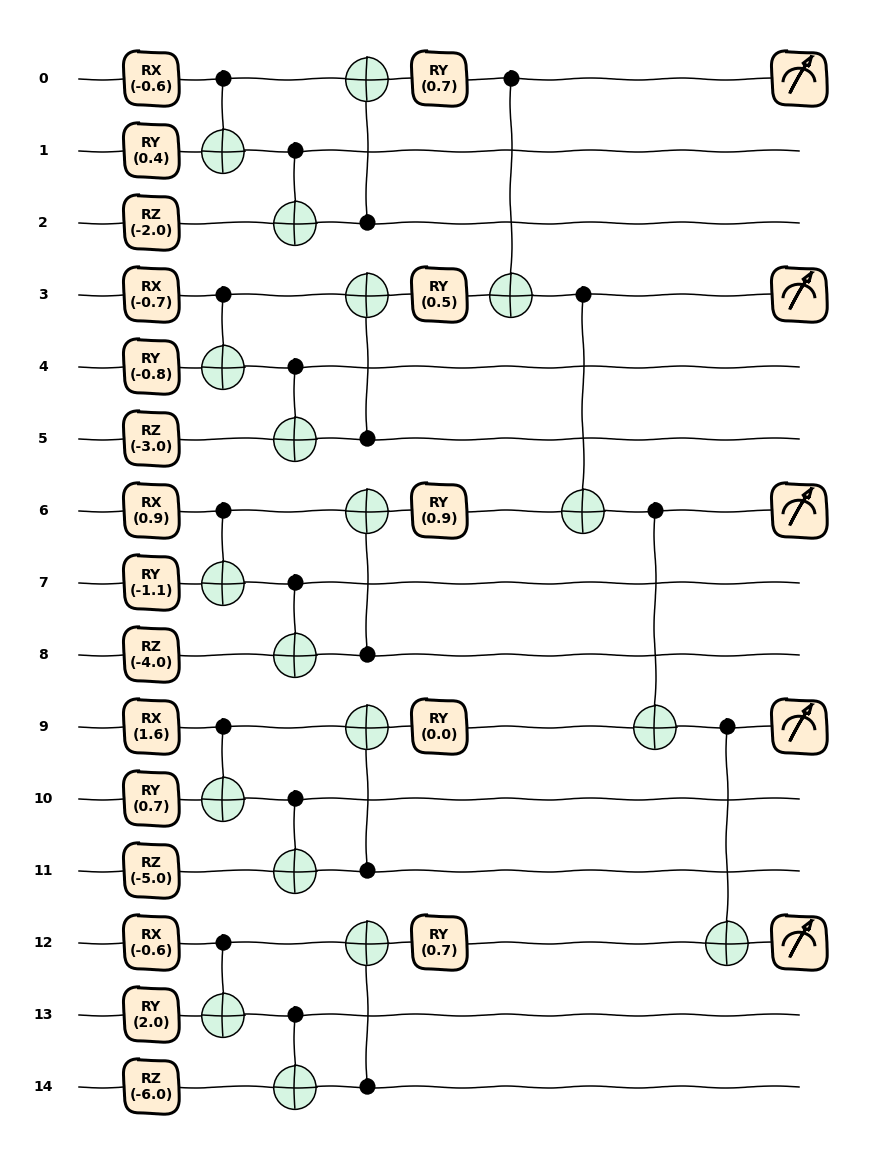

In [8]:
from qiskit import QuantumCircuit
import pennylane as qml
from qiskit.circuit import Parameter
# Flatten data
raw_data=new_df[:cut].values
X=raw_data.flatten()
# Create a quantum circuit with Nv qubits
Nv = len(raw_data)
num_qubits = Nv * 3  # 3 qubits per row (x,y,z)
# Initialize a quantum circuit
# Define a list of trainable parameters for the entanglement
num_params = len(A)  # Number of trainable parameters for the entanglement
ansatz = np.random.random(size=(num_params))
def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(3):
                if j==0:
                    qml.RX(X[i*3+j], wires = i * 3 + j)
                elif j==1:
                    qml.RY(X[i*3+j], wires = i * 3 + j)
                else:
                    qml.RZ(X[i*3+j], wires = i * 3 + j)
            #Entangle 3 positions
            qml.CNOT(wires = [i * 3, i * 3 + 1])
            qml.CNOT(wires = [i * 3 + 1, i * 3 + 2])
            qml.CNOT(wires = [i * 3 + 2, i * 3])
            # Encode each feature value into a qubit 
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * 3)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * 3, j * 3])
        return [qml.expval(qml.PauliZ(i*3)) for i in range(Nv)]

dev = qml.device("default.qubit", wires=3*Nv)
qnode = qml.QNode(quantum_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(X,ansatz)
plt.show()

In [9]:
look = [0 for _ in range(len(A))]
for i in range(len(A)):
    for j in range(i + 1, len(A)):
        if A[i][j] == 1:
            look[j]=1
#Edge info is collected in look
#Would like to compare it with QNN output
print("Compare Y with the following positions..")
print(look)

Compare Y with the following positions..
[0, 1, 1, 1, 1]


In [15]:
# Initialize a measurement quantum circuit
def circuit(X, ansatz):
    dev = qml.device('default.qubit', wires=Nv*3)
    @qml.qnode(dev)
    def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(3):
                if j==0:
                    qml.RX(X[i*3+j], wires = i * 3 + j)
                elif j==1:
                    qml.RY(X[i*3+j], wires = i * 3 + j)
                else:
                    qml.RZ(X[i*3+j], wires = i * 3 + j)
        #Entangle 3 positions
        qml.CNOT(wires = [i * 3, i * 3 + 1])
        qml.CNOT(wires = [i * 3 + 1, i * 3 + 2])
        qml.CNOT(wires = [i * 3 + 2, i * 3])
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * 3)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * 3, j * 3])
        return [qml.expval(qml.PauliZ(i*3)) for i in range(Nv)]
    expectations = quantum_circuit(X, ansatz)
    return expectations
# Prepare data for training (quantum circuits and labels)
Y_org = [0,1,1,1,1]  # True edge labels of dimension
epsilon=0.01
Y=Y_org.copy()
#Need to regularize Y to prevent Log(0) in loss function
for i in range(len(Y_org)):
    if Y[i]==0:
        Y[i]+=epsilon
    else:
        Y[i]-=epsilon
#Binary entropy loss function
def binary(x,xp):
    res=[x[i]*np.log(1-xp[i])+(1-x[i])*np.log(xp[i])
        for i in range(len(x))]
    return -(1/len(x))*sum(res)
def costfunc(params):
    cost = binary(circuit(X, params),Y[:Nv])
    return cost
from pennylane import numpy as np
#Initialize trainable parameters
ansatz = np.random.normal(0, 0.01, size=(num_params), requires_grad=True)
#Set-up the optimizer
optimizer = qml.AdamOptimizer(stepsize=0.01)
previous_cost = float('inf')  # Set to a large initial value
# A small threshold to check for convergence
tolerance = 1e-4  
#Training start
for k in range(30):
    cost=costfunc(ansatz)
    if k % 3 == 0:
        print(f"Step {k}, cost: {cost}")
    if abs(cost - previous_cost) < tolerance:
        print(f"Converged at step {k}, cost: {cost}")
        break
    ansatz = optimizer.step(costfunc, ansatz)
    previous_cost=cost

Step 0, cost: 1.0942593914689713
Step 3, cost: 1.0931445712342167
Step 6, cost: 1.0908346582209931
Step 9, cost: 1.0872319707101779
Step 12, cost: 1.0822332979012808
Step 15, cost: 1.0757473435413947
Step 18, cost: 1.0677039326735018
Step 21, cost: 1.0580617865034145
Step 24, cost: 1.0468146079337648
Step 27, cost: 1.0339951126551792


In [17]:
#Measure with the fixed parameters
dev = qml.device('default.qubit', wires=Nv*4)
@qml.qnode(dev)
def measure(X,ansatz):
    expect = quantum_circuit(X,ansatz)
    return expect
result=measure(X,ansatz)
def zeroOne(arr):
    return [1 if n>0.5 else 0 for n in arr]
print("Compare the result ",zeroOne(result)," with ",Y_org)

Compare the result  [1, 1, 0, 0, 0]  with  [0, 1, 1, 1, 1]
